# Geometric Sample Bias

Seminal work by Terzaghi (1965) revealed a geometric bias generated 
by sampling a three-dimensional fracture network with a line. 
Simply put, geometric sample bias (aka scanline sample bias) occurs 
because fractures perpendicular to a well are very likely to be intersected 
whereas those parallel to a well are almost never intersected. 
This geometric sample bias generates a 'blind zone' in fracture datasets 
where those which are near-parallel to the scan-line or well-path are rarely sampled. 

Terzaghi (1965) proposed a methodology quantifies the geometric sample 
bias using the acute angle (alpha) between the fracture plane and 
the line. Visualising the blind zone (where sin(alpha) +/- 0.3) and 
contours of sample bias (isogenic contours) on a stereonet enables
us to visually evaluate the degree that geometric sample bias in 
affects a fracture dataset.  

A weighting may be applied based on the alpha angle which may correct
the sampled fracture population to something more reflective of actual
frequency. Today this Terzaghi correction is common-place and some form 
of it is included in most image log analysis software. But there are 
two fundamental issues with the Terzaghi correction: 

- The weighting may mislead the interpreter emphasising solitary fractures that are not part of some significant but under-sampled population. This is most likely to occur where the weighting approaches infinity (i.e., near sin α = 0).
- The weighing can only be applied to fractures that were sampled and cannot correct for fractures that are absent from the dataset, such as those in the blind zone.

The first issue is partially resolved by setting an upper limit of 
sin α = 0.1 when calculating weighting, essentially truncating the 
weighting. Without inventing data, which would introduce more 
uncertainty, the second issue cannot be resolved numerically. 

The fractoolbox includes functions developed to deal with geometric sample bias by:
1. Constructing isogenic contours for stereonets so the effect of sample bias and the blind zone are visible to the interpreter and
2. Weighting fracture populations to reduce the impact of geometric sample bias 

The code in this notebook illustrates the workflow for using these functions.

In [1]:
import fractoolbox as ftb

from matplotlib import pyplot as plt
import numpy as np
import math
import pandas as pd
import mplstereonet

%matplotlib inline

## Import data and calculate strike from dip-direction

In [2]:
# import survey data
survey = pd.read_csv(r'testdata-survey.csv')

# add a plunge column to the survey data
survey['plunge'] = 90 - survey['inclination_deg']

# import the image log data
fracs = pd.read_csv(r'testdata-fractures.csv')

# calculate strike using right hand rule
strike = [] 
for n in fracs['dipazimuth_deg']:
    strike.append(ftb.dip2strike(n))
fracs['strike360'] = strike

# print number of fractures
# -------------------------
print('N = ',fracs.shape)

N =  (1142, 5)


## Generate data for isogenic contours

In [4]:
# trim the survey data to logged interval
survey_trimmed = survey[
    (survey.depth_mMDRF < 2152) & 
    (survey.depth_mMDRF > 1219)
    ]

# calculate the isogenic contour for mean well plunge & azimuth
wpl = survey_trimmed['plunge'].mean()
waz = survey_trimmed['azimuth_deg'].mean()

all_contours = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]
contours_with_blindzone = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0]
contours = contours_with_blindzone
    
iso_strike = []
iso_dip = []
for contour in contours:
    s, d = ftb.isogeniccontour(wpl, waz, contour)
    iso_strike.append(s)
    iso_dip.append(d)

## Plot fracture poles and isogenic contours

Isogenic contours for the test data show moderate impact from the blind zone. The presence of the approximately northwest-striking fractures within the blind zone indicates that there is likely a strong, high-angle cluster. 

Refer to fractoolbox/published-case-study/2-stereonets.ipynb to see a range of case studies and how they are impacted by the blind zone. 

[]

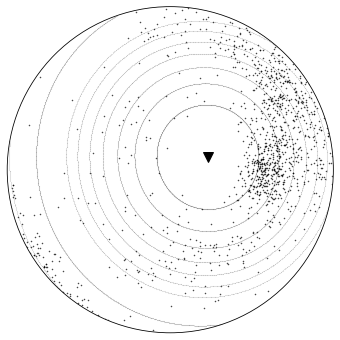

In [5]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111, projection='equal_area_stereonet')

ax1.pole(fracs.strike360, fracs.dip_deg, color='k', markersize=0.5, alpha=0.8)

# plot the isogenic contours
ax1.pole(iso_strike,iso_dip,'.',markersize=0.08,color='k')

# plot the well
ax1.line(wpl,waz,marker='v',markersize=10,color='k')

# remove labels
ax1.set_azimuth_ticklabels([])

## Calculate Terzaghi correction for fractures

In [6]:
# interpolate and append well plunge 
mDdat = fracs['depth_mMDRF']
mDsur = survey['depth_mMDRF']
xsur = survey['easting_m']
ysur = survey['northing_m']
zsur = survey['plunge']

dfxyz1 = ftb.xyzinterp(mDdat, mDsur, xsur, ysur, zsur) 
dfxyz1.columns = ['Dpth_mMDRT_1','Northing_1','Easting_1','wellplunge']
fracs = pd.concat([fracs,dfxyz1], axis=1, join='inner')

# interpolate and append well azumuth 
mDdat = fracs['depth_mMDRF']
mDsur = survey['depth_mMDRF']
xsur = survey['easting_m']
ysur = survey['northing_m']
zsur = survey['azimuth_deg']

dfxyz2 = ftb.xyzinterp(mDdat, mDsur, xsur, ysur, zsur) 
dfxyz2.columns = ['Dpth_mMDRT_2','Northing_2','Easting_2','wellazi']
fracs = pd.concat([fracs,dfxyz2], axis=1, join='inner')

# drop excess coloumns from dataframe
fracs = fracs.drop(['Dpth_mMDRT_2','Northing_2','Easting_2','Dpth_mMDRT_1','Northing_1','Easting_1',],1)

# calculate the unit vectors for the well at each fracture depth
fracs['wx'] = ftb.unitvectorx(fracs['wellazi'],fracs['wellplunge'])
fracs['wy'] = ftb.unitvectory(fracs['wellazi'],fracs['wellplunge'])
fracs['wz'] = ftb.unitvectorz(fracs['wellazi'],fracs['wellplunge'])

# calculate the unit vectors for the fracture dip/dipaz
fracs['fx'] = ftb.unitvectorx(fracs['dipazimuth_deg'],fracs['dip_deg'])
fracs['fy'] = ftb.unitvectory(fracs['dipazimuth_deg'],fracs['dip_deg'])
fracs['fz'] = ftb.unitvectorz(fracs['dipazimuth_deg'],fracs['dip_deg'])

# calculate alpha angle between the well and fracture
fracs['alpha'] = np.arccos(
    fracs['wx']*fracs['fx'] + 
    fracs['wy']*fracs['fy'] + 
    fracs['wz']*fracs['fz'] 
    )

# calculate sin(aplha)
fracs['sin(alpha)'] = np.sin(fracs['alpha'])

# calculate the weighting
fracs['weight'] = 1 / fracs['sin(alpha)']

# Plot contoured poles: Raw data density and Terzaghi corrected

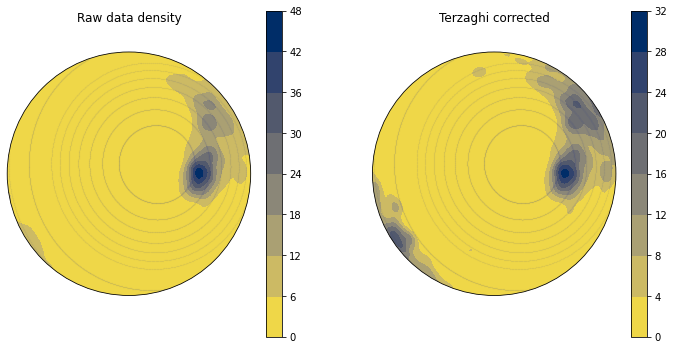

In [10]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121, projection='equal_area_stereonet')

uncorrected = ax1.density_contourf(
    fracs.strike360, 
    fracs.dip_deg, 
    #vmin=0., vmax=50., # fixes colour bar range 
    measurement='poles', 
    cmap='cividis_r')
fig.colorbar(uncorrected)

ax1.set_azimuth_ticklabels([]) 
ax1.set_title('Raw data density',y=1.1)


ax2 = fig.add_subplot(122, projection='equal_area_stereonet')

corrected = ax2.density_contourf(
    fracs.strike360, 
    fracs.dip_deg,
    #vmin=0., vmax=50., # fixes colour bar range 
    measurement='poles',
    weights=fracs['weight'].to_list(), 
    cmap='cividis_r')

fig.colorbar(corrected)

ax2.set_azimuth_ticklabels([]) 
ax2.set_title('Terzaghi corrected',y=1.1)

# plot fracture poles
#for ax in [ax1,ax2]:    
#    ax.pole(fracs.strike360, fracs.dip_deg, color='k', markersize=0.5, alpha=0.8)

# plot isogenic contours
ms = 0.03
c = '#3c5295'
for ax in [ax1,ax2]:
    ax.pole(iso_strike,iso_dip,'.',markersize=ms,color=c)

plt.show()

Contouring raw data reveals a strong fracture cluster with a north-striking centre and a northwest-striking high angle cluster with a much smaller number of fractures fractures. Contouring the weighted poles indicates that the high-angle, northwest-striking cluster is likely more impacted by sample bias than the the lower angle north-striking cluster. Both trends should be considered when applying these data to interpreting reservoir structure and patterns of fluid flow. 

## Citations

Terzaghi, R. D., 1965, Sources of error in joint surveys: Geotechnique, 
    v. 15, no. 3, p. 287-304.

Wallis, I.C., Rowland, J. V. and Dempsey, D. E., Allan, G., Sidik, R., 
    Martikno, R., McLean, K., Sihotang, M., Azis, M. and Baroek, M. 
    2020 (submitted) Approaches to imaging feedzone diversity with 
    case studies from Sumatra, Indonesia, and the Taupō Volcanic Zone, 
    New Zealand. New Zealand Geothermal Workshop: Waitangi, New Zealand.

In [57]:
%load_ext watermark
print('\n')
print('author:')
%watermark -a "Irene Wallis" -d
print('\n')
print('requirements:')
%watermark -v -p watermark,numpy,math,pandas,matplotlib,mplstereonet
print('\n')
print('fractoolbox.py')
print('\n')
%watermark -g

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


author:
Irene Wallis 2021-02-08


requirements:
CPython 3.7.7
IPython 7.15.0

watermark 2.0.2
numpy 1.18.1
math unknown
pandas 1.0.5
matplotlib 3.2.2
mplstereonet 0.6.dev0


fractoolbox.py


Git hash: d6745f960bad26213291de8db7b6969d77934397
